# Trading Strategies

The trem algorithmic trading strategy is used to describe any type of financeil trading strategy that us based on an algorithmic designed to take long, short, or neutral positions in financial instruments on its own without human interference. The chapter focuses on the technical aspects of the vectorized backtesting approach for a selected few such strategies.

Another focus of the chapter is the application of machine and deep learning algorithm to formualte algorithmic trading stategies.

## Simple Moving Averates

### Data Import

In [3]:
# import packages
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import seaborn as sns

sns.set()
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [4]:
raw = pd.read_csv('./source/tr_eikon_eod_data.csv', index_col=0, parse_dates=True)

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [6]:
symbol = 'AAPL.O'

data = (
    pd.DataFrame(raw[symbol]).dropna()
)

### Trading Strategy

The calculation of the SAM values for two dirrerent rolling window sizes. 

<Axes: xlabel='Date'>

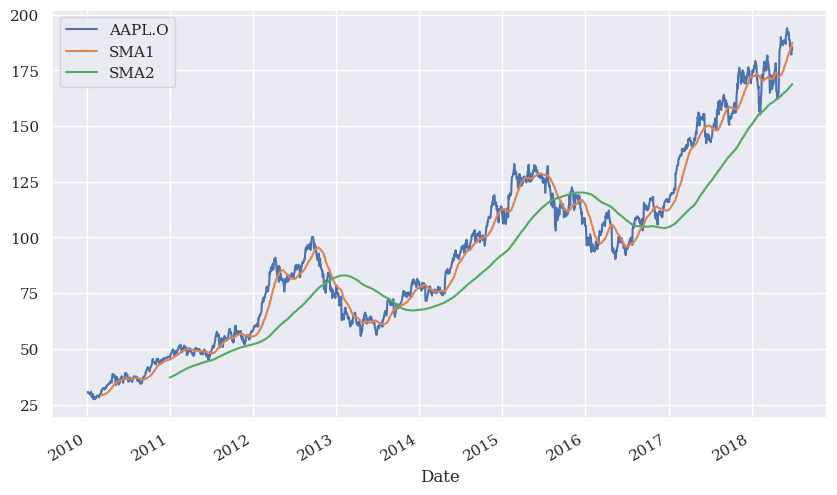

In [7]:
SMA1 = 42           # Calculates the values for the shorter SMA
SMA2 = 252          # Calculates the values fot the longer SMA

data['SMA1'] = data[symbol].rolling(SMA1).mean()
data['SMA2'] = data[symbol].rolling(SMA2).mean()

data.plot(figsize=(10, 6))

The derivation of the positions. The traing rule are:

- Go long (= +1) when the shorter SMA is above the longer SMA.

- Go short (= -1) when the shorter SMA is below the longer SMA

The poisitons are visualized below.

In [8]:
data.dropna(inplace=True)

data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1) 

data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


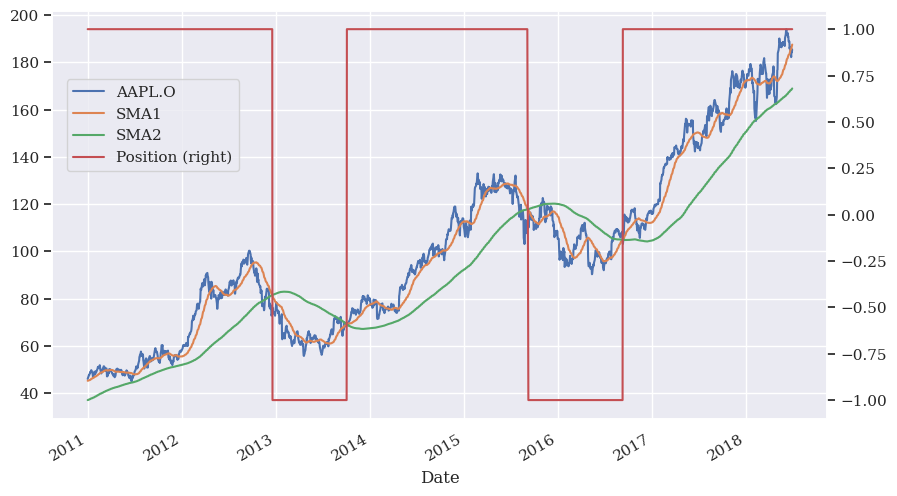

In [9]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

### Vectorized Backtesting

First, the log returns are calculated. Then the positionings, represented as +1 or -1, are muliplied by the relevant log return. This simple calculation is possible since a long position earns the return of the Apple stock and a short position earns the negative return of the Apple stock. Finally, the log returns for the Apple stock and the algorithmic traing strategy based on SMAs need to be added up and the exponential function applied to arriva at the performace values.

In [14]:
# calculates the log returns of the Apple stock
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))          

data['Strategy'] = data['Position'].shift(1) * data['Returns']          # Multiplies the postion values, shifted by one day, by the log returns of the Apple stock; the shift is required to avoid a foresight bias

In [15]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,strategy,Strategy
Date,,,,,,,
2011-01-03,47.0814,45.3497,37.1862,1,NaN,0.0215,NaN
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008,-0.0008
2011-01-07,48.0171,45.5821,37.4625,1,0.0071,0.0071,0.0071


In [16]:
data.dropna(inplace=True)

In [17]:
# Sums up the log returns for the stategy and the benchmark investment and calculates the exponential value to arrive at the absolute performance
np.exp(data[['Returns', 'Strategy']].sum())

Returns     3.931703
Strategy    5.687692
dtype: float64

In [18]:
# calculates the annualized volatility for the strategy and the benchmark investment
data[['Returns', 'Strategy']].std() * 252 ** 0.5            

Returns     0.250523
Strategy    0.250360
dtype: float64

The numbers show that the algorithmic trading strategy indeed outperforms the benchmark investment of passively holding the Apple stock.

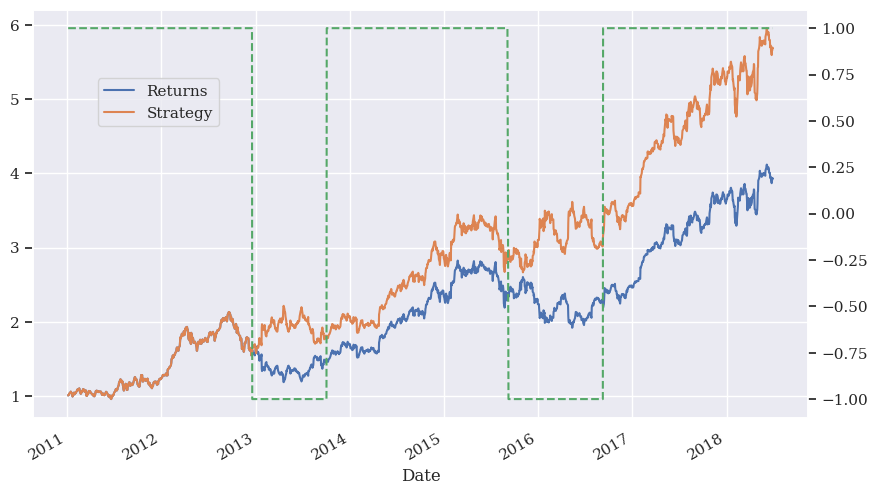

In [19]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

### Optimization